建物データと浸水面標高ラスターデータから建物の被災データを生成。（必要手続き：Driveの接続）

integratinonKeyとprojectIDが共に設定されている場合、Re:EarthCMSへのアップロードを行います。最後に出力される各種URLを、Re:Earthの編集画面に入力してください。

In [ ]:
# @title Googleドライブの準備
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title 設定するパラメータ

# ケース名：解析を通して使います。
casename = "omuta-r2" #-giaj" #"kurume-r2" #"kurume-r2-GIAJ"

obsdate = "2020-07-09" #"2020-07-09" #"2020-07-10"
satellite = "ASNARO-2" #"国土地理院" #"Sentinel-1"

# 浸水範囲を求める際に設定した最大水深
maxdepth = 7 #0# 4.27 # Set 0 for GIAJ

# Re:Earthへのアップロード用
# 片方でも None の場合はアップロードされません。
integrationKey = None # インテグレーションキー（文字列）
projectId = None # プロジェクトページのURLより（文字列）

# 確認用画像出力用フラグ
flg_checkDips = False

In [ ]:
# @title 詳細設定用パラメータ（基本的には操作不要）

enable_savefig = False # 図をGoogleドライブに保存する？

zoomlevel = 15 # DEM zoom level to fetch

# デバッグ用出力
global globalflag_debug

# 保存先
path_home = "/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/"
#path_cgml = path_home + "/CityGML/"
path_dem = path_home + "/DEM/"
path_case = path_home + casename + "/"
path_upload = path_case + "ForUpload/"
file_fldbbox = path_case + "floodprb_bbox.npy"
json_boundary = path_case +"boundary.json"
file_bbox = path_case + "boundbox.npy"

file_flooddem = path_case + "flood_dem_{:04d}.npz"
file_flooddepth = path_case + "flood_depth_{:04d}.npz"
file_building_csv = path_upload + "buildings.csv"

path_flood3Dtile_tmp =  "flood3dtile_depth/"
path_deltphtile_tmp = "ellipsoid_xyztiles/"
file_flood3Dtile_zip = path_upload+"3dtiles.zip"
file_floodXYZtile_zip = path_upload+"xyztile.zip"
file_floodHeattile_yukauemokuzou_zip = path_upload+"heatmap_yukaue_mokuzou.zip"
file_floodHeattile_yukashitamokuzou_zip = path_upload+"heatmap_yukashita_mokuzou.zip"
file_floodHeattile_allmokuzou_zip = path_upload+"heatmap_all_mokuzou.zip"

In [ ]:
#!pip list

In [ ]:
#@title ライブラリインポート
!pip install plateauutils
!pip install reearthcmsapi
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade scikit-image

import matplotlib.pyplot as plt
import numpy as np
from shapely import box
#from scipy import interpolate
from progressbar import progressbar
import zipfile
import os
import sys
import shutil
import plateauutils
import reearthcmsapi
from plateauutils.flood_converter.flood_to_3dtiles import FloodTo3dtiles
from plateauutils.flood_converter.flood_to_png import FloodToPng
from reearthcmsapi.apis.tags import items_api
from reearthcmsapi.model.versioned_item import VersionedItem
from reearthcmsapi.model.asset_embedding import AssetEmbedding
from reearthcmsapi.apis.tags import assets_project_api
from reearthcmsapi.model.asset import Asset
from pprint import pprint
sys.path.append(path_home)
import plateau_floodsar_lib as pfsl

In [ ]:
if not os.path.exists(path_upload):
  os.mkdir(path_upload)

## 浸水データ読み込みと楕円体高への変換、浸水カテゴリラスターの生成

In [ ]:
# @title 領域の読み込み
boundbox = np.load(file_fldbbox)
print(boundbox)

[130.36314377  32.99282306 130.50902244  33.11636148]


In [ ]:
# @title ジオイド高マップ取得
bbox = box(*boundbox)
print(bbox)
ggh = pfsl.GiajGeoidHandler(path_home)
ggh.load_dem_tiles(bbox)
tile = ggh.produce_tile_stiched()
geo_data = tile["geoid"]
geo_lons = tile["lons"]
geo_lats = tile["lats"]
idx_l = np.where(boundbox[0] <= geo_lons)[0][0]-1
idx_h = np.where(boundbox[2] < geo_lons)[0][0]+1
#print(idx_l, idx_h)
idy_l = np.where(boundbox[3] >= geo_lats)[0][0]-1
idy_h = np.where(boundbox[1] > geo_lats)[0][0]+1
#print(idy_l, idy_h)
geo_data = geo_data[idy_l:idy_h+1,idx_l:idx_h+1]
geo_lons = geo_lons[idx_l:idx_h+1]
geo_lats = geo_lats[idy_l:idy_h+1]

100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


POLYGON ((130.50902243702782 32.992823060359456, 130.50902243702782 33.116361482386736, 130.36314376664728 33.116361482386736, 130.36314376664728 32.992823060359456, 130.50902243702782 32.992823060359456))


[130.36314377  32.99282306 130.50902244  33.11636148]


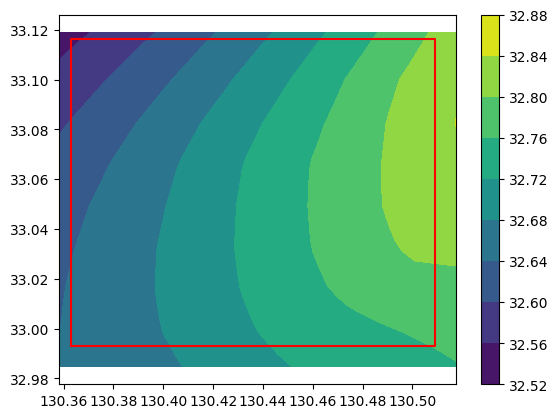

In [ ]:
#@title ジオイド高の確認
if flg_checkDips:
  print(boundbox)
  boxline_x = [boundbox[0],boundbox[2],boundbox[2],boundbox[0],boundbox[0]]
  boxline_y = [boundbox[1],boundbox[1],boundbox[3],boundbox[3],boundbox[1]]
  ax =plt.subplot(1,1,1)
  #img = ax.contourf(geo_data)#,levels=np.arange(1,cnt+10,10))
  img = ax.contourf(geo_lons, geo_lats, geo_data)#,levels=np.arange(1,cnt+10,10))
  plt.plot(boxline_x,boxline_y, "r-")
  ax.axis("equal")
  plt.colorbar(img)

In [ ]:
#@title 浸水DEMラスターの読み込みと確認
dem_map = np.load(file_flooddem.format(int(maxdepth*100)))
lons = dem_map["lons"]
lats = dem_map["lats"]
demmap = dem_map["floodmap_dem"]

if flg_checkDips:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, demmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)

In [ ]:
print(geo_lats)
print(lats[10], geo_lats[len(np.where(geo_lats>lats[10])[0])-1])
print(geo_lons)
print(lons[3000], geo_lons[len(np.where(geo_lons<lons[3000])[0])-1])

[33.11897495 33.11434453 33.10971411 33.10508369 33.10045327 33.09582285 33.09119243 33.08656201 33.08193159 33.07730117 33.07267075 33.06804033 33.06340991 33.05877949 33.05414907 33.04951865 33.04488823 33.04025782 33.0356274  33.03099698 33.02636656 33.02173614 33.01710572 33.0124753  33.00784488 33.00321446 32.99858404 32.99395362 32.9893232  32.98469278]
33.118735993487796 33.118974951702874
[130.35827637 130.36376953 130.3692627  130.37475586 130.38024902 130.38574219 130.39123535 130.39672852 130.40222168 130.40771484 130.41320801 130.41870117 130.42419434 130.4296875  130.43518066 130.44067383 130.44616699 130.45166016 130.45715332 130.46264648 130.46813965 130.47363281 130.47912598 130.48461914 130.4901123  130.49560547 130.50109863 130.5065918  130.51208496 130.51757812]
130.48152923583984 130.4791259765625


In [ ]:
#@title 楕円体高への変換
print(len(geo_lats), len(geo_lons), np.shape(geo_data))

# scipy.interpolate is temporaly unavailable here
# Once it is comming back, comment out the alternative code
# and bring back the original code.

#from scipy.interpolate import RectBivariateSpline
#geoInterp = interpolate.RectBivariateSpline(geo_lats[::-1], geo_lons, geo_data[::-1,::])
#tmp = geoInterp(lats[::-1],lons)[::-1,:]

# original code ends here

# alternative code starts here
# with linear interpolation
tmp = np.zeros_like(demmap)
for jj in progressbar(np.arange(len(lats))):
  idyl = len(np.where(geo_lats>lats[jj])[0])-1
  wyh = (lats[jj]-geo_lats[idyl])/(geo_lats[idyl+1]-geo_lats[idyl])
  wyl = 1-wyh
  idyh = idyl+2
  wryl = 0
  wryh = 2
  if idyl < 0:
    idyl = 0
    idyh = idyl + 1
    wyh = 1
    wryl = 1
  elif idyl >= len(geo_lats):
    idyl = len(geo_lats)-1
    idyh = idyl + 1
    wyl = 1
    wryh = 1
  for ii in np.arange(len(lons)):
    idxl = len(np.where(geo_lons<lons[ii])[0])-1
    wxh = (lons[jj]-geo_lons[idxl])/(geo_lons[idxl+1]-geo_lons[idxl])
    wxl = 1-wxh
    idxh = idxl+2
    wrxl = 0
    wrxh = 2
    if idxl < 0:
      idxl = 0
      idxh = idxl + 1
      wxh = 1
      wrxl = 1
    elif idxl >= len(geo_lons)-1:
      idxl = len(geo_lons)-1
      idxh = idxl + 1
      wxl = 1
      wrxh = 1

    #weight = np.array([[wyl*wxl, wyl*wxh],[wyl*wxh, wyh*wxh]])
    #print((idyl, idxl))#, weight[wryl:wryh,wrxl:wrxh],geo_data[idyl:idyh,idxl:idxh] )
    #tmp[jj,ii] = np.sum(weight[wryl:wryh,wrxl:wrxh] * geo_data[idyl:idyh,idxl:idxh])
    tmp[jj,ii] = geo_data[idyl,idxl]
# alternative code ends here

print(np.shape(tmp), np.max(tmp), np.min(tmp))
geomap = demmap + tmp
#print("\nUp to ", len(lons))
#for ii, lon in progressbar(enumerate(lons)):
#  for jj,lat in enumerate(lats):
#    demmap[jj,ii] += ggh.calc_dem_interp(lon, lat)

  0% (0 of 3584) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

30 30 (30, 30)


100% (3584 of 3584) |####################| Elapsed Time: 0:01:40 Time:  0:01:40


(3584, 3840) 32.8333 32.5416


(3840, 3584, (3584, 3840))


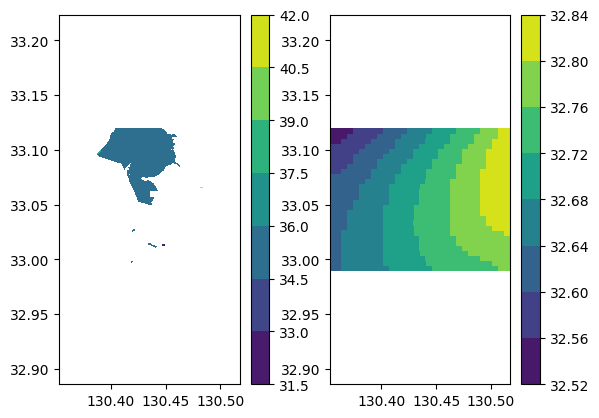

In [ ]:
#@title 浸水ジオイド高確認用
if flg_checkDips:
  print((len(lons), len(lats), np.shape(geomap)))
  ax =plt.subplot(1,2,1)
  img = ax.contourf(lons,lats, geomap)#,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)

  ax =plt.subplot(1,2,2)
  img = ax.contourf(lons,lats, tmp)#,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)

In [ ]:
#@title 浸水深ラスターの読み込みと確認
depth_map = np.load(file_flooddepth.format(int(maxdepth*100)))
depthmap = depth_map["floodmap_depth"]

if flg_checkDips:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, depthmap)#,levels=np.arange(0,maxdepth+0.1,0.25))
  ax.axis("equal")
  plt.colorbar(img)

In [ ]:
#@title 浸水カテゴリラスターの生成と確認
classificationmap = np.zeros_like(depthmap, dtype="int32")
classification_levels = [0,0.5,5,10,20]
#classificationmap[np.where(depthmap >= classification_levels[2])] = len(classification_levels)
#classificationmap[np.where(depthmap < classification_levels[1])] = len(classification_levels)
for ii, vv in enumerate(classification_levels[::-1][:-1]):
  print(ii, vv)
  classificationmap[np.where(depthmap < vv)] = len(classification_levels) - ii

if flg_checkDips:
  ax =plt.subplot(1,1,1)
  img = ax.contourf(lons,lats, classificationmap,levels=np.arange(-1,len(classification_levels)+1))
  ax.axis("equal")
  plt.xlim([130.50, 130.53])
  plt.ylim([33.32, 33.34])
  plt.colorbar(img)

0 20
1 10
2 5
3 0.5


## アップロード用タイルの生成

In [ ]:
#@title XYZタイル分けされた点郡NPZファイルの生成関数
#print(len(lats)/256.0, len(lons)/256.0)

def save_tile_npz(lats,lons,map, classificationmap, zoom=15, dst_dir ="temp/"):
  dir_zoom = dst_dir + f"{zoom}/"
  if not os.path.exists(dir_zoom):
    os.makedirs(dir_zoom)
  res_lons = np.array([])
  res_lats = np.array([])
  res_maps = np.array([])
  res_class = np.array([])
  print(f" / total loop num: {len(lats)/256}")
  for jj, tmp_lat in progressbar(enumerate(lats[::256])):
    idj = jj*256
    sublats = lats[idj:idj+256]
    for ii, tmp_lon in enumerate(lons[::256]):
      idi = ii*256
      sublons = lons[idi:idi+256]
      xx,yy  = pfsl.calc_xyz_from_lonlat(tmp_lon, tmp_lat, zoom)
      #print(ii,jj, xx, yy)
      submap = map[idj:idj+256,idi:idi+256]
      subclass = classificationmap[idj:idj+256,idi:idi+256]
      grd_lons, grd_lats  = np.meshgrid(sublons,sublats)
      flt_lons = grd_lons.ravel()
      flt_lats = grd_lats.ravel()
      flt_map = submap.ravel()
      flt_class = subclass.ravel()
      #selected = [[lon,lat,dem] for lon, lat, dem in zip(flt_lons, flt_lats,flt_map) if not np.isnan(dem)]
      #print(flt_lons[0:5])
      #print(flt_lats[0:5])
      #print(flt_map[0:5])
      #print(ii, jj, f"{subzoom}-{xx}-{yy}", f"{subzoom}-{chk_tile[0]}-{chk_tile[1]}")
      if not os.path.exists(f"{dir_zoom}{xx}"):
        os.mkdir(f"{dir_zoom}{xx}")
      np.savez(f"{dir_zoom}{xx}/{yy}.npz", lons=flt_lons, lats=flt_lats, dem=flt_map, classification=flt_class)
      res_lons = np.append(res_lons, flt_lons)
      res_lats = np.append(res_lats, flt_lats)
      res_maps = np.append(res_maps, flt_map)
      res_class = np.append(res_class, flt_class)
  return res_lons, res_lats, res_maps, res_class


In [ ]:
tilecnv = FloodTo3dtiles()

In [ ]:
if os.path.exists("/ellipsoid_tmp"):
  !rm -rf /ellipsoid_tmp
test_lons, test_lats, test_maps, test_class = save_tile_npz(lats,lons,geomap, classificationmap,dst_dir="/ellipsoid_tmp/")
#shutil.make_archive(path_upload+"flood_xyznpz","zip", root_dir = "/ellipsoid")
if os.path.exists("/3dtile_tmp"):
  !rm -rf /3dtile_tmp
tilecnv.convert("/ellipsoid_tmp/", "/3dtile_tmp/")
shutil.make_archive(file_flood3Dtile_zip[:-4], 'zip', "/3dtile_tmp/")

if os.path.exists("/XYZtile_tmp"):
  !rm -rf /tile_tmp
p = FloodToPng("/ellipsoid_tmp/")
p.parse("/XYZtile_tmp/")
shutil.make_archive(file_floodXYZtile_zip[:-4], 'zip', "/XYZtile_tmp/")

/ |#                                                  | 0 Elapsed Time: 0:00:00

 / total loop num: 14.0


| |      #                                           | 13 Elapsed Time: 0:00:20


 100.0 % in 35 sec [est. time left: 0 sec]      

'/content/drive/MyDrive/plateau-2023-uc01-satellite-analytics/PLATEAU-FloodSAR/omuta-r2/ForUpload/xyztile.zip'

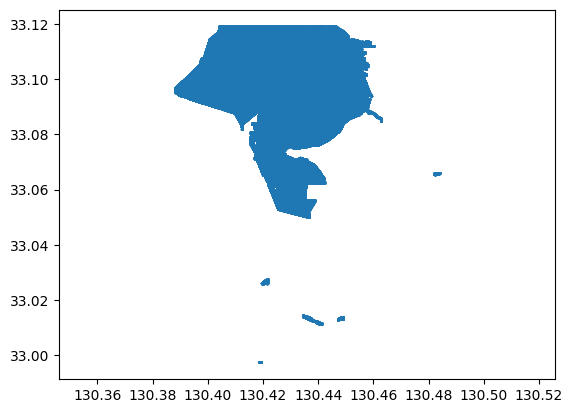

In [ ]:
#@title 点郡確認用（CSV出力コードあり）
if  True: #flg_checkDips:
  plt_lons = test_lons[np.where(~np.isnan(test_maps))]
  plt_lats = test_lats[np.where(~np.isnan(test_maps))]
  plt_dems = test_maps[np.where(~np.isnan(test_maps))]
  plt_clss = test_class[np.where(~np.isnan(test_maps))]
  plt.scatter(plt_lons,plt_lats, s=0.5)
  plt.axis("equal")
  if True: # Set True to produce CSV of 3d Tile information
    with open(path_upload+"3dtiles.csv", "w") as ofile:
      ofile.write("lon,lat,dem,category\n")
      for tmplon, tmplat, tmpdem, tmpclss in zip(plt_lons, plt_lats, plt_dems, plt_clss):
        ofile.write(f"{tmplon},{tmplat},{tmpdem},{tmpclss}\n")

## Re:EarthCMSへのアップロード

In [ ]:
#@title Re:Earth CMSへのアップロード
if integrationKey is not None and projectId is not None:
  configuration = reearthcmsapi.Configuration(
      host = "https://api.cms.test.reearth.dev/api",
      access_token = integrationKey
  )

  client = reearthcmsapi.ApiClient(configuration)

  api_client = reearthcmsapi.ApiClient(configuration)
  api_instance = assets_project_api.AssetsProjectApi(api_client)

  # Create an instance of the API class
  api_instance = assets_project_api.AssetsProjectApi(api_client)
  path_params = {
      'projectId': projectId,
  }

  uploadlist = [
      [file_flood3Dtile_zip, "浸水域・浸水深（3Dタイル）\n{ff}/tileset.json"],
      [file_floodXYZtile_zip, "浸水域・浸水深（画像タイル）\n{ff}/{z}/{x}/{y}.png"],
      [file_building_csv, "建物被災状況（CSVファイル）\n{ff}.csv"],
      [file_floodHeattile_yukauemokuzou_zip,"被災建物・ヒートマップ画像タイル：床上（木造）\n{ff}/{z}/{x}/{y}.png"],
      [file_floodHeattile_yukashitamokuzou_zip,"被災建物・ヒートマップ画像タイル：床下（木造）\n{ff}/{z}/{x}/{y}.png"],
      [file_floodHeattile_allmokuzou_zip,"被災建物・ヒートマップ画像タイル:木造家屋総数\n{ff}/{z}/{x}/{y}.png"]
  ]
  outtxt = ""
  for ff, txt in uploadlist:
    body = dict(
        file=open(ff, 'rb'),
        skip_decompression=False,
    )
    try:
        # Create an new asset.
        api_response = api_instance.asset_create(
            path_params=path_params,
            body=body,
        )
        #pprint(api_response)
        outtxt += txt.format(ff=api_response.body["url"][:-4],x="{x}",y="{y}",z="{z}")+"\n\n"
    except reearthcmsapi.ApiException as e:
        print("Exception when calling AssetsProjectApi->asset_create: %s\n" % e)

  print("以下の情報をRe:Earth編集画面に入力してください。")
  print("------------------------------------------------")
  print(f"観測日: {obsdate}")
  print(f"観測衛星: {satellite}")
  print()
  print(outtxt)
else:
  print("Re:Earth CMSへのアップロードは行われませんでした。")